In [1]:
import numpy as np
import matplotlib.pyplot as plt
import finesse
from finesse.analysis.actions import RunLocks
from finesse import ligo
finesse.configure(plotting=True)

In [2]:
fl = 1/2.898550724637681e-05
print(f"changed the lens* to len using diopters=1/f: {fl:.16f}")

changed the lens* to len using diopters=1/f: 34500.0000000000000000


1. It can't recognize lens* (use diopters instead of fl)
2. "ValueError: In block 'laser': jitter: Node 'ni' already assigned to 'L0'.": added a space of zero between laser and jitter (s L0Jitter 0 ni njitter)
3. "In block 'squeezer': M1_OPO: Node 'nSQZ' already assigned to 'sqz'.": similar solution as above (s sqzM1_OPO 0 nSQZ nM1_OPO). But also need to make the change (gauss* g_nSQZ M1_OPO nM1_OPO -0.054 0.139036143294069 since nSQZ is no longer a node of M1_OPO component)

In [3]:
designF3 = finesse.Model()
designF3.parse_legacy_file("./design.kat")
# kat.parse_legacy_file("./LLO.kat")
print(designF3.unparse())
print("#### The parse_legacy_file function worked! ####")

laser L0 P=125.0
space L0Jitter portA=L0.p1 portB=jitter.p1
beamsplitter jitter R=1.0 T=0.0 L=0.0
space lmod1 portA=jitter.p2 portB=mod1.p1 L=1.0
modulator mod1 f=9099471.0 midx=0.18
space lmod2 portA=mod1.p2 portB=mod2.p1 L=1.0
modulator mod2 f=45497355.0 midx=0.18
space sIMCin portA=mod2.p2 portB=MC1.p1
beamsplitter MC1 R=0.994 T=0.006 L=0.0 alpha=44.59
space sMC1_MC2 portA=MC1.p3 portB=MC2.p1 L=16.24057
beamsplitter MC2 R=1.0 T=0.0 L=0.0 alpha=0.82 Rc=[27.24, 27.24]
space sMC2_MC3 portA=MC2.p2 portB=MC3.p1 L=16.24057
beamsplitter MC3 R=0.994 T=0.006 L=0.0 alpha=44.59
space sMC3substrate portA=MC3.p3 portB=MC3AR.p1 L=0.0845 nr=1.44963098985906
beamsplitter MC3AR R=0.0 T=1.0 L=0.0 alpha=28.9661
space sMC3_MC1 portA=MC3.p2 portB=MC1.p4 L=0.465
space sHAM2in portA=MC3AR.p3 portB=IM1.p1 L=0.4282
beamsplitter IM1 R=1.0 T=0.0 L=0.0 alpha=53.0
space sIM1_IM2 portA=IM1.p2 portB=IM2.p1 L=1.2938
beamsplitter IM2 R=1.0 T=0.0 L=0.0 alpha=7.0 Rc=[12.8, 12.8]
space sIM2_FI portA=IM2.p2 portB=FI.p1

In [9]:
designF3QNLS = designF3.deepcopy()

designF3QNLS.parse("""
###############################################################################
### Length sensing and control
###############################################################################
variable f1 9099471.0
variable f2 5*&f1
dof XARM ETMX.dofs.z 1 
dof YARM ETMY.dofs.z 1 
dof CARM ETMX.dofs.z 1 ETMY.dofs.z 1    
dof DARM ETMX.dofs.z 1 ETMY.dofs.z -1 DC=0.000775490275302556    
dof PRCL PRM.dofs.z 1  
dof SRCL SRM.dofs.z 1   DC=89.99999999999999
dof MICH BS.dofs.z 1  
dof MICH2 ITMY.dofs.z 1 ETMY.dofs.z 1 ITMX.dofs.z -1 ETMX.dofs.z -1        
dof STRAIN LX.dofs.h 1 LY.dofs.h -1    
dof FRQ L0.dofs.frq 1 
dof RIN L0.dofs.amp 1 

readout_rf REFL9 PRMAR.p1.o f=&f1 phase=5.276114879012382 output_detectors=true
readout_rf REFL18 PRMAR.p1.o f=(3*&f1)
readout_rf REFL45 PRMAR.p1.o f=(5*&f1)
readout_rf POP9  PR2.p3.o   f=&f1 phase=-169.13734272154758 output_detectors=true
readout_rf POP45 PR2.p3.o   f=&f2 phase=177.83524272452797 output_detectors=true
readout_rf AS45  SRMAR.p2.o f=&f2 phase=-6.146945800670171 output_detectors=true
readout_dc AS    OMC_OC.p3.o output_detectors=true

lock CARM_lock REFL9_I CARM.DC -0.00010310899995708841 1e-6
lock MICH_lock POP45_Q MICH.DC 16.69737563119658 1e-6
lock PRCL_lock POP9_I PRCL.DC -2.923409080736336 1e-6
lock SRCL_lock POP45_I SRCL.DC -43.220106415336616 1e-6
lock DARM_rf_lock AS45_I DARM.DC -0.00339832744582408 1e-6 disabled=true
lock DARM_dc_lock AS_DC DARM.DC -0.01 1e-6  disabled=false offset=20m


fsig(1)
sgen darmx LX.h
sgen darmy LY.h phase=180
    
# Output the full quantum noise limited sensitivity
qnoised qnoise SRM.p2.o nsr=True
xaxis(darmx.f, log, 10, 5k, 100, pre_step=run_locks(method='newton', display_progress=false))
""")

/opt/anaconda3/envs/finesse3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


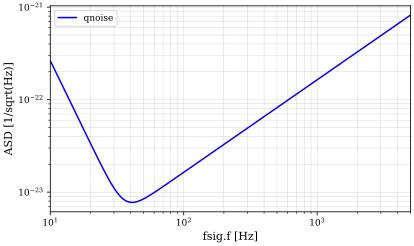

In [10]:
out = designF3QNLS.run()
out.plot("qnoise", log=True, separate=False);